# Bykeli 
_______

## This Document


!not yet done!

Bykeli is a sensorbased tool for a quality-driven analysis of bikelanes

This document shows the how to calculate the **happy bike index** and **event processing** of acceleration sensor data recorded. The are some resrictions.


- input: physics-toolbox (App) delivers formated and geotagged acceleration data recorded with android smartphones
- output: geotags of relevant events (:geojson)



Debateable issues and prospects:
- relevancy of extrapolated events; events need to be labeled (preferably during recording)
- integrity of data (eg. samples are not equidistant)
- algorithm precision: kernel-size of filters should be dependent of sample/record-size
____

*Author: Matthias Franz-Josef Rötzer (c)*

In [19]:
import os

import pandas as pd
import numpy as np
import matplotlib

import scipy 
from scipy import ndimage

import matplotlib.pyplot as plt

#for determining calc time
import time

%matplotlib inline
np.random.seed(0)

In [20]:
from geojson import FeatureCollection, Feature, LineString, GeometryCollection, Point

"""
!obsolete processing function!

:TODO
- not yet compatible with dataframes in this doc
- rewrite get_next_gps_entry()
- set invariants for df_acc, df_gps
- calculation of bykeli index is obsolete 
- check for unnecessary loops
"""

def process_df_old(df, axis = 'ax', kernel=30):
    """
    Processes the given data frame, calculates the Bykeli-Index
    and returns the result as GeoJSON
    
    :returns GeoJSON object
    """
    
    entries = []
    for i in range(kernel, len(df) - kernel):
       item = df.iloc[i]
       acc_value = item[axis] # 1,05 (str) to 1.05 (float)
       lng = item['Longitude']
       lat = item['Latitude']
        
       items_before = df[axis].iloc[i-kernel:i]
       items_after = df[axis].iloc[i:i+kernel]
       env = (items_before, items_after) 
        
       entry = {'lng': lng, 
                'lat': lat, 
                'index': calculate_bykeli_index(acc_value, 
                                                values_before=items_before, 
                                                values_after=items_after,
                                                std=df[axis].std()
                                               )
               }
       entries.append(entry)
    
    # Step 2: Convert to GeoJSON
    features = []
    for i in range(0, len(entries)-2):
        x = entries [i]
        y = entries[i+1]
        line = LineString([(x['lng'], x['lat']), 
                           (y['lng'], y['lat'])])
        feature = Feature(geometry=line, properties={
            "index": x['index'],
            "stroke": index_to_color(x['index']),
            "stroke-width": 2,
            "stroke-opacity": 1
        })
        
        features.append(feature)
        
    return FeatureCollection(features)

## Toolbox

In [2]:
def import_csv(path_dat):
    try:
        df_dat = pd.read_csv(path_dat, delimiter = ';')
    except:
        print "import error"
        
    return df_dat

In [3]:
def summarize(df_dat):
    shp = df_dat.shape[0]
    leng = len(df_dat['Latitude'].unique())
    
    print"total length: %s \nunique geotags: %s" % (str(shp), str(leng))

In [4]:
def plot_XYZ(dat):
    X= dat['ax']
    Y = dat['ay']
    Z = dat['az']

    f, (axx, axy, axz) = plt.subplots(3, sharey = True)
    
    axx.plot((X))
    axx.set_title("X")
    
    axy.plot((Y))
    axy.set_title("Y")
    
    axz.plot((Z));
    axz.set_title("Z")
    
    plt.tight_layout()

In [5]:
def str_to_float(value):
    
    """ 
    3,141 (str) --> 3.141 (float)
    """
    if isinstance(value, float) or isinstance(value, int):
        return float(value)
    else:
        return float(value.replace(',', '.'))

In [6]:
def calculate_bykeli_index(value, values_before, values_after, std):
    """
    Returns the Bykeli-Index for the given value. 
    
    :std Standardabweichung der Werte
    """
    # Calc average value
    l = [value] + list(values_before) + list(values_after)
    l = [abs(x) for x in l]
    avg = float(sum(l)) / float(len(l))
    
    value = avg
    
    MAX = std * 1.3
    i = abs(value)
    i = i / MAX
    i = round(i, 2)
    if i>1:
        return 1
    return i

In [7]:
def first_process(df_dat):
    """
    in: dataframe with format: -time-ax-ay-az-latitude-longitude
    drop duplicates
    get az ax ay as float 
    
    :returns absolutes of Z-acceleration ('az') with geotag
    """
    
    df_dat['az'] = df_dat['az'].str.replace(",",".").astype(float)
    df_dat['ay'] = df_dat['ay'].str.replace(",",".").astype(float)
    df_dat['ax'] = df_dat['ax'].str.replace(",",".").astype(float)
    
    # Absolutes of 'Z' ??
    #df_dat['az'] = abs(df_dat['az'])
    
    df_dat_out = df_dat.drop_duplicates(['Latitude','Longitude','az', 'ay', 'ax'], keep = 'last')
    
    return df_dat_out 

In [8]:
def plot_1d_broad(data, ylim = [0,1], log = 'null', name = 'my data'):
    fig = plt.figure(figsize=(15,4))
    ax = fig.add_subplot(111)
    ax.plot(data)
    ax.grid(True)
    ax.set_ylim(ylim)
    
    #set log
    if(log == 'log'):
        ax.set_yscale("log")
    
    ax.set_title(name)

In [9]:
def normalize(data):
    """takes pandas.Series"""
    
    min_data = min(data)
    maxi_data = max(data)
    reach = (maxi_data - min_data)
    
    normalize = pd.Series(data)
    
    for key, val in data.iteritems():
        normalize[key] = (val - min_data)/ reach
        
    return normalize

In [10]:
def standardize(data):
    """
    !bugged!
    statistical standarization (of x):
    z_i = (x_i - x_mean) / x_standardDeviation
    :TODO invariants
    """
    
    descr = data.describe()
    std = descr['std']
    mean = descr['mean']
    
    standardize = pd.Series(data)
    
    for key, val in data.iteritems():
        standardize[key] = (data[key] - mean) / std
    
    return standardize

In [11]:
def set_same(x,y):
    """sets arrays to the same size"""
    shp = min(len(x),len(y))
    return x[:shp],y[:shp]

In [12]:
def drop(data):
    """ dropping duplicate geotags"""
    len_before = len(data)
    data_dupl = data.drop_duplicates(['Latitude', 'Longitude'], keep = 'last')
    data_dupl = data_dupl.reset_index(drop = 'last')
    
    dropped = len_before - len(data_dupl)
    print "%d duplicates dropped" % dropped
    
    return data_dupl

In [21]:
def average_geotags(data):
    
    """
    :in df with 
    indices?
    
    :returns geotags with accumulated average of the z-acceleration
    
    """
    df = data
    
    df_geotags = pd.DataFrame(columns = ['az', 'Latitude', 'Longitude'])
    i = 0
    k = 0

    lat = df['Latitude'].iloc[0]
    lon = data['Longitude'].iloc[0]

    sum1 = 0

    while(i < df.shape[0]-1):
        if(lat == df['Latitude'].iloc[i+1] and lon == df['Longitude'].iloc[i+1]):
            sum1 += df['az'].iloc[i]
            k += 1
            i += 1
        else:
            avg = sum1/k
            df_geotags.loc[i] = [avg, lat, lon]
            k = 0
            sum1 = 0
            i+=1
            lat = df['Latitude'].iloc[i]
            lon = df['Longitude'].iloc[i]
            
    return df_geotags

In [22]:
def gauss_me(g_kernel, sigma, mu = 0):
    """gaussian vector"""
    k = int(g_kernel/2+.5)
    window = np.linspace(-k,k,g_kernel)

    g = np.exp(-((window - mu)**2 / ( 2.0 * sigma**2 ) ) )/np.sqrt(2*np.pi*sigma**2); #efficiency?
    return g

## geoJSON Toolbox

In [23]:
def index_to_color(index):  
    """
    return color for value between 0 and 1 
    
    color gradient green, yellow, red 
    """
    color_gradient = [
            '#2bff00', '#74ff00', '#9eff00', '#bfff00', '#dcff00',
            '#ebef00', '#f7e000', '#ffd000', '#ffad00', '#ff8700',
            '#ff5b00', '#ff0000'
        ]
    i = index * len(color_gradient)
    return color_gradient[int(round(i)) - 1]

In [24]:
def dump(data, filename):
    import json
    f = open(base_path+'processed.geojson', 'w') 
    f.write(json.dumps(data))

In [25]:
def df_to_geojson(df, export_path=None, lat_row='Latitude', lng_row='Longitude'):
    """ 
    Konvertiert das Dataframe der GPS Sensoraufnahme (GPS.csv) in GeoJSON (ohne Index-Berechnung). 
    """
    points = []
    for i in range(0, len(df)):
        x = df.iloc[i]
        p = Point(str_to_float(x[lng_row]), str_to_float(x[lat_row]))
        
        points.append(p)
    
    _geojson = GeometryCollection(points)
    
    if export_path:
        f = open (export_path, 'w')
        f.write(json.dumps(_geojson))
    return _geojson


### Processing proposal

In [36]:
def process_df(df, infohash, axis = 'az', export_path = 0, kernel=25, srate = 100, sigma = 1):
    
    """
    Processes the given data frame, calculates the Bykeli-Index
    and returns the result as GeoJSON
    
    :TODO
    add sampling rate as parameter
    complete infohash
    :returns GeoJSON object
    """
    
    tic = time.clock()
    
    infohash['kernel'] = kernel
    infohash['export'] = export_path
    infohash['sampling_rate'] = srate
    
    # step 1 
    # formating and cleanup of data
    if(infohash['preprocessed'] == 0):
        df = first_process(df)
        df_Z = df.loc[:,['az','Latitude','Longitude']]
        df_Z['az'] = abs(df_Z['az'])
        infohash['preprocessed'] = 1
        df = df_Z
    
    descr = df.describe()
    descr['az']['count']
    infohash["n_entries0"] = descr['az']['count']
    
    # step 2 
    # denoising
    
    mu, sigma = 0, sigma
    g_kernel = kernel # really?
    gwindow = gauss_me(g_kernel,sigma, mu)
    
    ## get error value
    sum_g = 0
    for i in range(0,len(gwindow)):
        sum_g += gwindow[i]
    infohash['error_gaussian'] = abs(1-sum_g)
    
    ## convolution with G and ignoring the borders
    df['azg'] = np.convolve(gwindow, df['az'], 'same')
    
    # step 3 
    # calculate HBI 
    # :TODO this drops the indices
    
    ## reindex 
    df['index_key'] = df.index
    df.reset_index(drop = 'true')
    ## averages of geotags
    avg_g = average_geotags(df)
    infohash['n_unique_geotags'] = len(avg_g)
    ## standardize df -> {[0,1)}
    
    avg_g['az'] = normalize(avg_g['az'])
    print avg_g.head()
    df = avg_g
    
    # step 4 export
    
    entries = []
    for i in range(0, len(df)):

        item = df.iloc[i]
        lng = str_to_float(item['Longitude'])
        lat = str_to_float(item['Latitude'])
        index = item['az']

        entry = {'lng': lng, 
                'lat': lat, 
                'index': index
                }

        entries.append(entry)
    
    ## Convert to GeoJSON
    features = []
    for i in range(0, len(entries)-2):
        x = entries [i]
        y = entries[i+1]
        line = LineString([(x['lng'], x['lat']), 
                           (y['lng'], y['lat'])])
        feature = Feature(geometry=line, properties={
            "index": x['index'],
            "stroke": index_to_color(x['index']),
            "stroke-width": 2,
            "stroke-opacity": 1
        })
        
        features.append(feature)
        
    _geojson = FeatureCollection(features)
    
    toc = time.clock()
    print toc-tic
    
    if export_path:
        f = open(export_path, 'w')
        f.write(json.dumps(_geojson))
        print "exported to " + export_path
    
    return FeatureCollection(features)

# Test run

In [39]:
dirpath = os.getcwd()
path_domrunde = "./data/raw/data_dom.csv" #:TODO 
export_path = dirpath

df_dat = import_csv(path_dat = path_domrunde)

In [40]:
infohash = dict({"n_entries0": 0,
                 "n_entries1": 0,
                 "n_unique_geotags":0,
                 "error_gaussian": 0,
                 "kernel": 0,
                 "sampling_rate": 0,
                 "sigma": 0,
                 "preprocessed": 0
                })

In [41]:
fc = process_df(df_dat, infohash, export_path = 0, kernel = 50, sigma = 3)

          az     Latitude    Longitude
27  0.000000  48,37163497  10,89763117
33  0.007430  48,37138519  10,89776818
39  0.017767  48,37141779  10,89782756
45  0.033128  48,37135772  10,89780973
51  0.001371  48,37133100  10,89785437
1.520181


In [ ]:
dat = [fc, infohash] #make it part of the processor

In [32]:
infohash

{'error_gaussian': 0.02000001145783925,
 'export': 0,
 'kernel': 50,
 'n_entries0': 2745.0,
 'n_entries1': 0,
 'n_unique_geotags': 410,
 'preprocessed': 1,
 'sampling_rate': 100,
 'sigma': 0}

## Data formating and Display

In [17]:
# first processing cleanup and format
# erste domrunde
# "./data/raw/data_dom.csv"

path_domrunde = "./data/raw/data_dom.csv"
path_zurswa = "./data/raw/zurswa.csv"

#df_dat = import_csv(path_domrunde)
df_dat = import_csv(path_zurswa)

df_dat_out = first_process(df_dat)
print "\npreprocsesed"
summarize(df_dat)
print "\npostprocessed: dropped duplicates (not geotag duplicates)"
summarize(df_dat_out)


preprocsesed
total length: 57744 
unique geotags: 484

postprocessed: dropped duplicates (not geotag duplicates)
total length: 3941 
unique geotags: 484


In [681]:
df = import_csv(path_zurswa)
df = first_process(df)
df_Z = df.loc[:,['time', 'az','Latitude','Longitude']]
df_Z['az'] = abs(df_Z['az'])
kernel = 25
mu, sigma = 0, 1
g_kernel = kernel
gwindow = gauss_me(g_kernel,sigma, mu)

sum_g = 0
for i in range(0,len(gwindow)):
    sum_g += gwindow[i]
    
df_Z['azg'] = np.convolve(gwindow, df_Z['az'], 'same')
#plot_1d_broad(df_Z['azg'], ylim = [0,max(df_Z['az'])])
df_Z.head()
df_Z['index_key'] = df_Z.index
df_Z.reset_index(drop = 'true')
avg_geo = average_geotags(df_Z)

total length: 3941 
unique geotags: 484


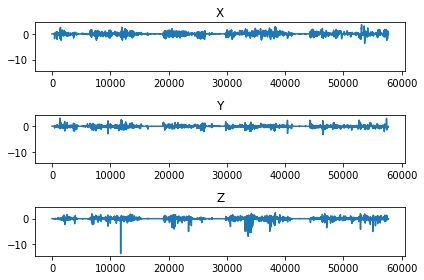

In [21]:
# postprocessed
plot_XYZ(df_dat_out)
summarize(df_dat_out)

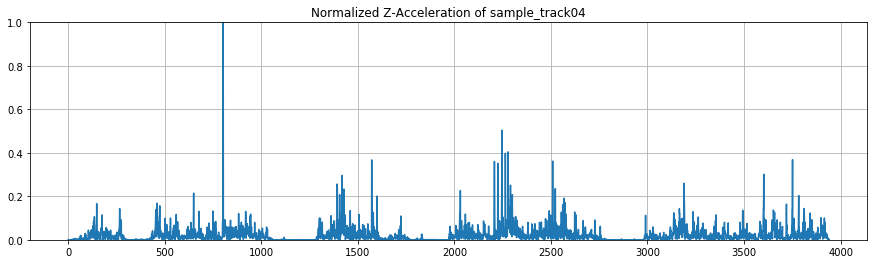

In [22]:
# extract, normalize, reindex and display Z-Acceleration
Z_norm = df_dat_out.loc[:,['az','Latitude','Longitude']]

#Absolute values of Z acclereation
Z_norm['az'] = abs(Z_norm['az'])

# set between 0 and 1
Z_norm['az'] = normalize(Z_norm['az'])

Z_norm = Z_norm.reset_index(drop = True)
#plot_1d_broad(Z_norm, name = 'Z normalized')
plot_1d_broad(Z_norm['az'], name = 'Normalized Z-Acceleration of sample_track04')

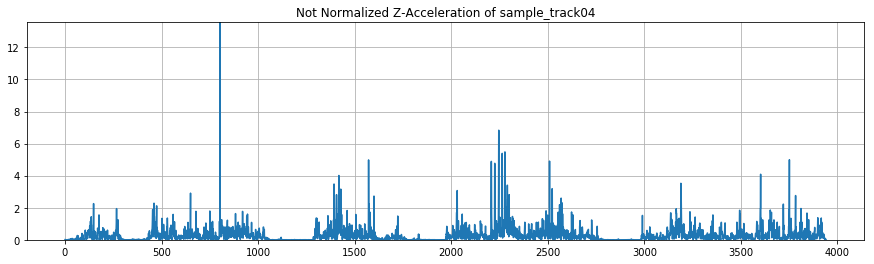

In [23]:
# extract, do not normalize, but reindex and display Z-Acceleration
Z = df_dat_out.loc[:,['az','Latitude','Longitude']]

#Absolute values of Z acclereation
Z['az'] = abs(Z['az'])

#rethink the following step!
Z = Z.reset_index(drop = True)
#plot_1d_broad(Z_norm, name = 'Z normalized')
plot_1d_broad(Z['az'], ylim = [0,max(Z['az'])],name = 'Not Normalized Z-Acceleration of sample_track04')

## Extracting of Events
### Using average metrics

In [24]:
# showing the median functionality 
i = 20

# Kernel is 2*k+1
kernel = 7
k = int(kernel/2)

#def median(data, kernel):
area = Z.loc[i - k : k + i, 'az']
med = pd.Series.median(area)
print "mean = %f \nkernel = %d \n \n" % (med, len(area)), area;

mean = 0.003800 
kernel = 7 
 
17    0.0217
18    0.0186
19    0.0186
20    0.0028
21    0.0038
22    0.0005
23    0.0003
Name: az, dtype: float64


In [35]:
def get_averages(data, kernel):
    """ same functionality as a box kernel convolution 
        :TODO data invariants
    """
    
    #k = int(kernel/2 + .5)
    N = int(len(data)/kernel)
    
    avg = pd.DataFrame(columns=['Z','Z_median', 'Z_mean'])
    avg['Z'] = data
    
    for i in range(0, N):
        
        #centric kernel
        #area = data.iloc[key - k : key + k]
        
        k_area = data.iloc[i*kernel:i*kernel+kernel]
        
        # use pandas' metrics functions
        med = pd.Series.median(k_area)
        mean = pd.Series.mean(k_area)
        
        avg.loc[i*kernel:i*kernel+kernel, 'Z_median'] = med
        avg.loc[i*kernel:i*kernel+kernel, 'Z_mean'] = mean
        #avg.loc[i*kernel:i*kernel+kernel, 'Z_hbi']
        
    return avg

In [43]:
# calculate median with a certain size (alias kernel) 

kernel = 5
avg_z = get_averages(data = Z['az'], kernel = kernel)

In [134]:
# due to kernel size the last data(mod kernelsize)=R are ignored
avg_z.tail(10)

,Z,Z_median,Z_mean
3931,0.0776,0.0933,0.1456
3932,0.1670,0.0933,0.1456
3933,0.0474,0.0933,0.1456
3934,0.0933,0.0933,0.1456
3935,0.0564,0.0564,0.03884
3936,0.0619,0.0564,0.03884
3937,0.0621,0.0564,0.03884
3938,0.0050,0.0564,0.03884
3939,0.0088,0.0564,0.03884
3940,0.0191,0.0564,0.03884


In [57]:
max(avg_z['Z_median'])

2.4153

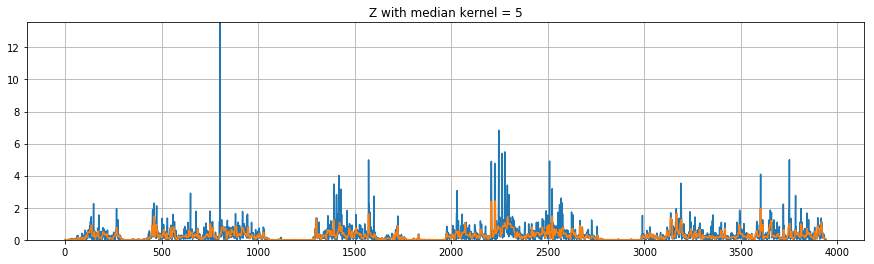

In [58]:
# median average with k kernel

title = 'Z with median kernel = ' + str(kernel)

plot_1d_broad(avg_z['Z'], name= title, ylim=[0,max(avg_z['Z'])])
plt.plot(avg_z['Z_median'])

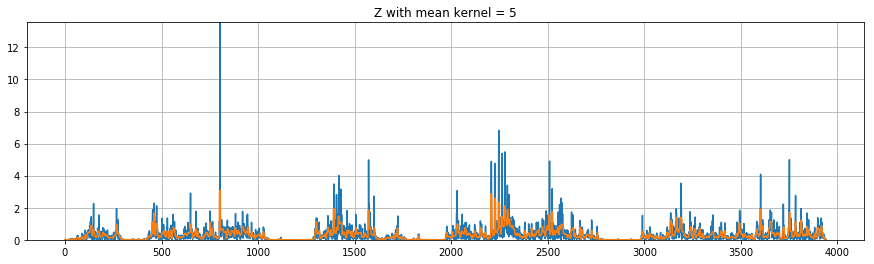

In [60]:
# arithmetic mean average 

title = 'Z with mean kernel = ' + str(kernel)

plot_1d_broad(avg_z['Z'], name= title, ylim=[0,max(avg_z['Z'])])
plt.plot(avg_z['Z_mean'])

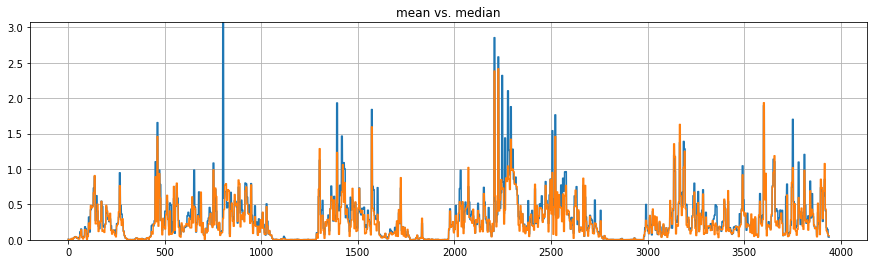

In [64]:
# mean vs. median 
ylim = [0,max(max(avg_z['Z_median']), max(avg_z['Z_mean']))]
plot_1d_broad(avg_z['Z_mean'], name = "mean vs. median", ylim = ylim)
plt.plot(avg_z['Z_median'])

In [65]:
# get normalized delta
delta_mean = abs(avg_z['Z'] - avg_z['Z_mean'])

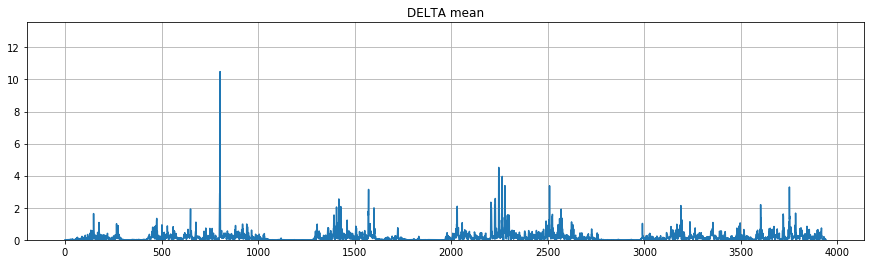

In [70]:
plot_1d_broad(delta_mean, name = 'DELTA mean', ylim = [0,max(avg_z['Z'])])

### Using Regression Analysis

In [ ]:
""" 
ignore this part

baustelle !

idee: mittels einer _nicht_ linearen regressions analyse
      das signal glätten      
      
"""
from sklearn import linear_model

# example for LINEAR regression
N = len(Z)
x = np.arange(N, dtype=float).reshape((N, 1))
y = np.array(Z['az']).reshape((N,1))
regr = linear_model.LinearRegression()

regr.fit(x,y)

pred = regr.predict(x)

print pred.shape

In [ ]:
def non_linear_regression(data, kernel):
    """ baustelle """
    
    N = int(len(data)/kernel)
    
    regr = pd.DataFrame(columns=['Z','Z_regr'])
    regr['Z'] = data
    
    for i in range(0, N-1):
        
        #centric kernel
        #area = data.iloc[key - k : key + k]
        
        x = np.arange(N, dtype=float).reshape((N, 1))
        
        regress_ker = # regression 
        
        regr.loc[i*kernel:i*kernel+kernel, 'Z_regr'] = regress_ker
            
    return regr

### Using Filters and Convolution

In [75]:
az = Z['az']

gaussian accuracy: 1.000000005350576

gaussian accuracy: 0.9999715875468381


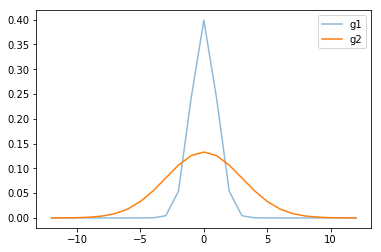

In [127]:
# kernel -> 2k+1 (3,5,9,...,251,...)
g_kernel = 25

#cstd = az.std()

# define gaussian vector
mu, sigma_1 = 0, 1
g_window_1 = gauss_me(g_kernel,sigma_1, mu)

mu, sigma_2 = 0, 3
g_window_2 = gauss_me(g_kernel,sigma_2, mu)

#get sum of gaussian-window (should be 1)
sum = 0
for i in range(0,len(g_window_1)):
    sum += g_window_1[i]
print "gaussian accuracy: " + str(sum) + '\n'

sum = 0
for i in range(0,len(g_window_2)):
    sum += g_window_2[i]
print "gaussian accuracy: " + str(sum)

k = int(g_kernel/2+.5)
window = np.linspace(-k,k,g_kernel)
plt.plot(window, g_window_1, label = 'g1', alpha = .5)
plt.plot(window, g_window_2, label = 'g2')
plt.legend();

In [86]:
processed_1 = np.convolve(g_window_1, az)
processed_2 = np.convolve(g_window_2, az)
delta_gauss = abs(processed_1 - processed_2)

In [166]:
descr = az.describe()
descr
#descr['count']

count    3941.000000
mean        0.310286
std         0.527385
min         0.000000
25%         0.026500
50%         0.149300
75%         0.400600
max        13.560100
Name: az, dtype: float64

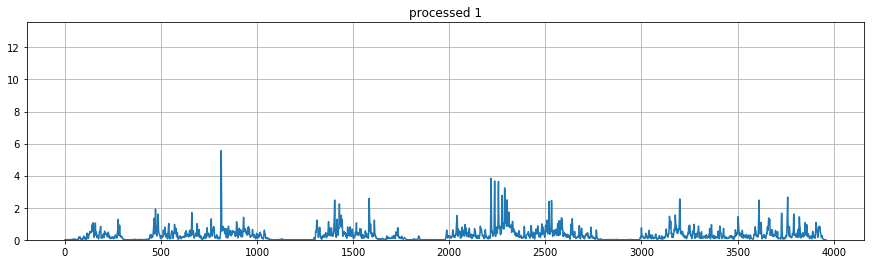

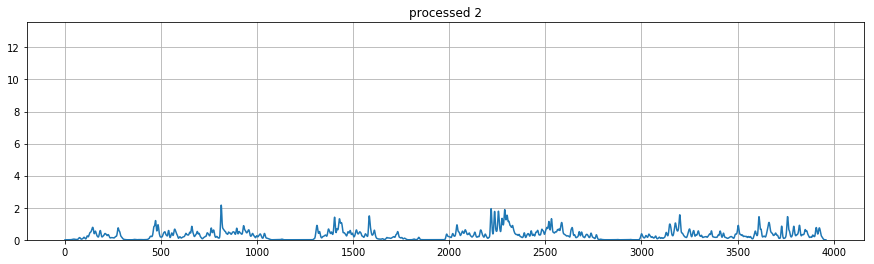

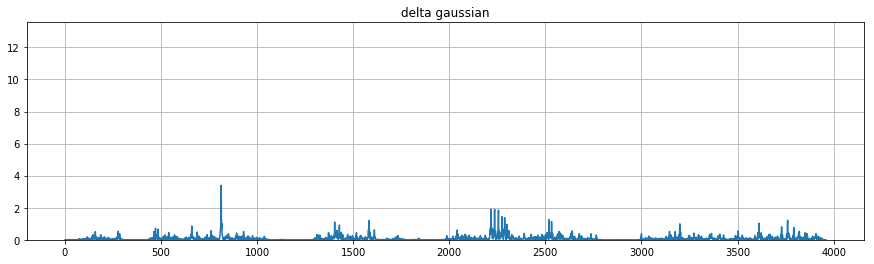

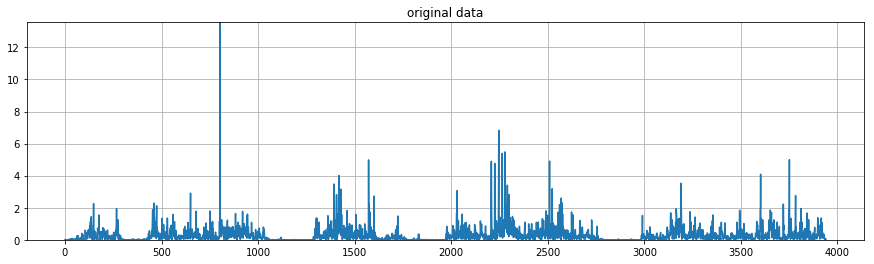

In [88]:
ylim = [0,max(az)]
plot_1d_broad(processed_1, ylim = ylim, name = "processed 1")
plot_1d_broad(processed_2, ylim = ylim, name = "processed 2")
plot_1d_broad(delta_gauss, ylim = ylim, name = "delta gaussian")
plot_1d_broad(az, ylim = ylim, name = "original data")

In [131]:
df_p1 = pd.DataFrame(processed_1, columns = ['Z'])
averages_p1 = get_averages(df_p1['Z'], 21)
averages_p1.head()

,Z,Z_median,Z_mean
0,6.309571e-25,0.00151252,0.00209027
1,8.429830e-21,0.00151252,0.00209027
2,4.143418e-17,0.00151252,0.00209027
3,7.493200e-14,0.00151252,0.00209027
4,4.987164e-11,0.00151252,0.00209027


In [163]:
processed_1.shape

(3961,)

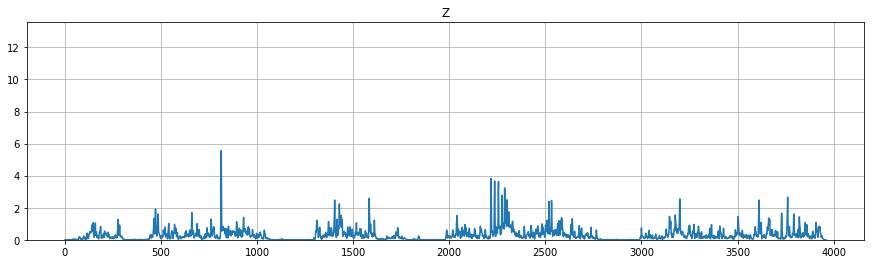

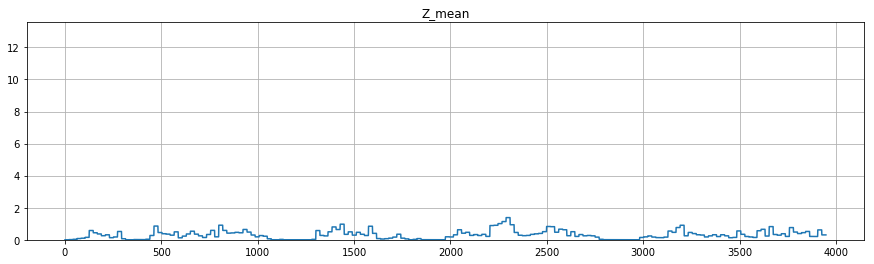

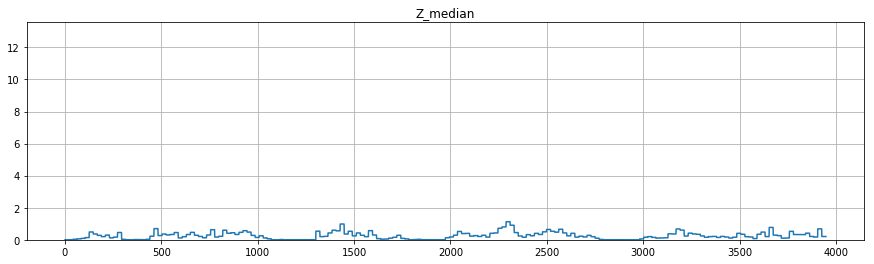

In [132]:
plot_1d_broad(averages_p1['Z'], ylim = ylim, name = "Z")
plot_1d_broad(averages_p1['Z_mean'], ylim = ylim, name = "Z_mean")
plot_1d_broad(averages_p1['Z_median'], ylim = ylim, name = "Z_median")

## Bolzplatz

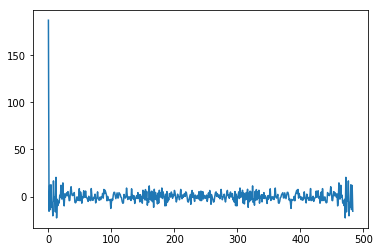

In [388]:
az = df_geotags['az']
fft_az = np.fft.fft(az)
plt.plot(fft_az.real)

In [113]:
from scipy import signal
fftconv_1 = signal.fftconvolve(az, g_window_1, mode = 'full')
fftconv_2 = signal.fftconvolve(az, g_window_2, mode = 'full')
plot_1d_broad(fftconv_1, ylim = ylim)
plot_1d_broad(fftconv_2, ylim = ylim)

In [ ]:
import scipy.stats as st

def gkern(kernlen, nsig):
    """Returns a 2D Gaussian kernel array"""
    interval = (2*nsig+1.)/(kernlen)
    x = np.linspace(-nsig-interval/2., nsig+interval/2., kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kernel_raw = np.sqrt(np.outer(kern1d, kern1d))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def gaussian(x, mu, sigma):
    """returns a 1D gaussian kernel with window x as input"""
    
    const = (1/(np.sqrt(2*np.pi*np.power(sigma,2.))))
    
    #for i in np.nditer(x):
    #   i = np.exp(-np.power((i-mu), 2.) / (2 * np.power(sigma, 2.)))
    return np.exp(-np.power((x-mu), 2.) / (2 * np.power(sigma, 2.)))

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

In [ ]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [ ]:
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    """ Konfidenzintervall """
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [38]:
"""
Zur Visualisierung im Jupyter notebook (setzt Folium vorraus)
""" 

import folium

def style_function(feature):
    return {
        "color": feature['properties']['stroke'],
        "stroke-width": 2,
        "stroke-opacity": 1
      }

m = folium.Map(location=[48.37142643, 10.89786328], zoom_start=19)
folium.GeoJson(fc, name='bikeindex', style_function=style_function).add_to(m)
